#### Import Required Libraries

In [34]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.features import rasterize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [35]:
#specify color for classification
colors = [
    "black",        # Class 0
    "darkgreen",    # Class 1
    "lightgreen",   # Class 2
    "#B8860B",      # Class 3 (Dark Yellow - DarkGoldenRod)
    "#800020",      # Class 4 (Burgundy)
    "#FF8C00",      # Class 5 (Dark Orange)
    "darkblue",     # Class 6
    "lightskyblue", # Class 7 (Light Blue)
    "#0ABAB5",      # Class 8 (Tiffany - a teal/cyan shade)
    "#556B2F",      # Class 9 (Other tone of green - DarkOliveGreen)
    "#FFD700",      # Class 10 (Other tone of yellow - Gold)
    "#FFB6C1",      # Class 11 (Light Red)
    "red",          # Class 12
    "#FFA07A",      # Class 13 (Light Orange - LightSalmon)
    "#FFFFE0"       # Class 14 (Light Yellow - LightYellow)
]

# Create a custom colormap
cmap = ListedColormap(colors)

#### Load the image and shape file data

In [36]:
# Paths to the data
raster_path = "SWIR_data/AVIRIS_C_SWIR.tif"
shapefile_path = "SWIR_data/training_data_SWIR.shp"

# Step 1: Load Raster Data
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    transform = src.transform

print(raster_data.shape)

# Step 2: Load Shapefile
shapefile = gpd.read_file(shapefile_path)

print(shapefile.head())

(86, 1163, 665)
    Shape_Leng    Shape_Area  classvalue classname  \
0   789.755128  44965.592253           1    class1   
1  1191.011552  95261.166155           1    class1   
2   839.174581  50118.375489           1    class1   
3   759.545936  36950.686188           1    class1   
4   616.456425  26192.592464           1    class1   

                                            geometry  
0  POLYGON ((487236.240 4152906.459, 487328.264 4...  
1  POLYGON ((485537.543 4149487.978, 485615.988 4...  
2  POLYGON ((487131.667 4150841.497, 487137.244 4...  
3  POLYGON ((483258.730 4154849.507, 483296.944 4...  
4  POLYGON ((483265.266 4156530.252, 483328.009 4...  


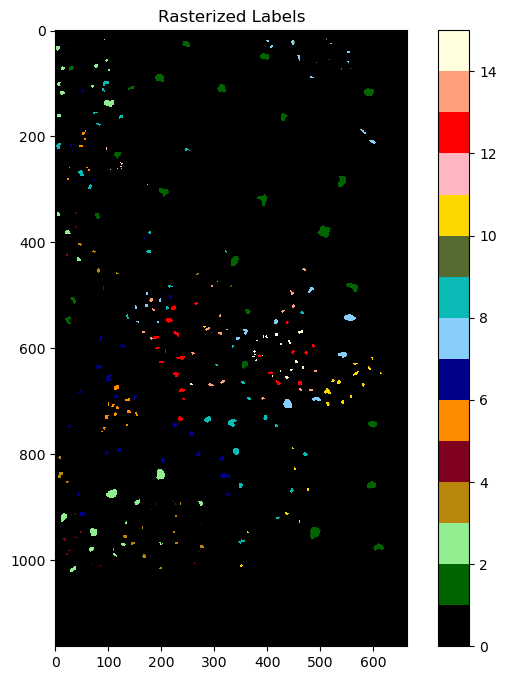

In [37]:
# Step 3: Rasterize Shapefile
shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['classvalue']))
rasterized_labels = rasterize(shapes, out_shape=raster_data.shape[1:], transform=transform)

# Display rasterized labels
plt.figure(figsize=(8, 8))
plt.imshow(rasterized_labels, cmap=cmap, interpolation="none")
plt.title("Rasterized Labels")
plt.colorbar()
plt.show()

#### Preparation of Training Data

In [38]:
# Step 4: Prepare Training Data

# Clip negative values to zero
raster_data_clipped = np.clip(raster_data, 0, None)

# Normalize the clipped raster data
raster_data_normalized = (raster_data_clipped - raster_data_clipped.min()) / (raster_data_clipped.max() - raster_data_clipped.min())

# Check min and max after clipping and normalization
print(f"Min value after clipping and normalization: {raster_data_normalized.min()}")
print(f"Max value after clipping and normalization: {raster_data_normalized.max()}")

Min value after clipping and normalization: 0.0
Max value after clipping and normalization: 1.0


In [39]:
# Flatten the raster and labels for pixel-based classification
X = raster_data_normalized.reshape(raster_data.shape[0], -1).T  # Shape: (num_pixels, num_channels)
y = rasterized_labels.flatten()  # Shape: (num_pixels,)

# Filter out unlabeled pixels (e.g., background where y == 0)
mask = y > 0
X = X[mask]
y = y[mask]

# Adjust labels to start from 0
y = y - 1

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape X_train and X_test to match 1D CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train shape: (10987, 86)
y_train shape: (10987,)
X_test shape: (2747, 86)
y_test shape: (2747,)


#### Define the 1D CNN model

In [42]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [43]:
# Initialize and compile the model
input_shape = (X_train_cnn.shape[1], 1) #each pixel is represented as a 1D vector of 86
num_classes = len(np.unique(y_train)) #number of unique class in training dataset
model = create_model(input_shape, num_classes) #init model 
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("model/best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#### Model training

In [44]:
# Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# Access the training history: loss, accuracy, validation loss, validation accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Print the training and validation loss/accuracy for each epoch
print("Training Loss: ", training_loss)
print("Validation Loss: ", validation_loss)
print("Training Accuracy: ", training_accuracy)
print("Validation Accuracy: ", validation_accuracy)

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 1.3191 - accuracy: 0.5982
Epoch 1: val_loss improved from inf to 4.76246, saving model to model\best_model.h5
86/86 [==============================] - 6s 55ms/step - loss: 1.3191 - accuracy: 0.5982 - val_loss: 4.7625 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 2/50
85/86 [============================>.] - ETA: 0s - loss: 0.6225 - accuracy: 0.7822
Epoch 2: val_loss did not improve from 4.76246
86/86 [==============================] - 4s 50ms/step - loss: 0.6220 - accuracy: 0.7828 - val_loss: 6.4124 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8601
Epoch 3: val_loss did not improve from 4.76246
86/86 [==============================] - 4s 51ms/step - loss: 0.4153 - accuracy: 0.8601 - val_loss: 7.6768 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 4/50
86/86 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8959
Epoch 4: val_loss

In [47]:
# Paths to the data
raster_path = "SWIR_data/AVIRIS_C_SWIR.tif"

# Load Raster Data
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    transform = src.transform

# Clip negative values to zero
raster_data_clipped = np.clip(raster_data, 0, None)

# Normalize the clipped data
raster_data_normalized = (raster_data_clipped - raster_data_clipped.min()) / (raster_data_clipped.max() - raster_data_clipped.min())

# Check min and max after clipping and normalization
print(f"Min value after clipping and normalization: {raster_data_normalized.min()}")
print(f"Max value after clipping and normalization: {raster_data_normalized.max()}")

Min value after clipping and normalization: 0.0
Max value after clipping and normalization: 1.0


In [49]:
# Step 1: Flatten the spatial dimensions (height x width) into a single dimension
num_pixels = raster_data_normalized.shape[1] * raster_data_normalized.shape[2]
num_bands = raster_data_normalized.shape[0]

# Reshape the data into (num_pixels, num_bands)
X_unlabeled = raster_data_normalized.reshape(num_bands, -1).T  # Shape: (num_pixels, num_bands)

# Step 2: Reshape the data into (num_pixels, num_bands, 1) for the 1D CNN
X_unlabeled_cnn = X_unlabeled.reshape(X_unlabeled.shape[0], X_unlabeled.shape[1], 1)

# Check the reshaped data shape
print(f"Reshaped X_unlabeled for 1D CNN: {X_unlabeled_cnn.shape}")

Reshaped X_unlabeled for 1D CNN: (773395, 86, 1)


In [68]:
# Simulate Oracle-Based Labeling
def oracle_labeling(X_query):
    """
    Simulate the oracle-based labeling by assigning random labels.
    Here, we simulate a binary classification by labeling each sample as either class 0 or class 1.
    """
    return np.random.choice([0, 1], size=X_query.shape[0])

# Initial labeled data (you already have these)
X_train_labeled = X_train_cnn  # Your CNN training data
y_train_labeled = y_train      # Labels corresponding to X_train_cnn

# Unlabeled data (raw raster data for active learning)
X_unlabeled = X_unlabeled_cnn  # Your raw raster data

# Initialize y_unlabeled (it will grow as we add queried samples)
y_unlabeled = np.array([])  # Initially empty

# Active learning loop
for iteration in range(max_iterations):
    print(f"=== Active Learning Iteration {iteration + 1} ===")
    
    
    # Define ModelCheckpoint to save the best model based on validation loss
    model_checkpoint = ModelCheckpoint(
        "model/best_model_active_learning.h5",
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=1
    )

    # Create and compile a new model for this iteration
    model = create_model(input_shape=(X_train_labeled.shape[1], 1), num_classes=num_classes)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define additional callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    
    
    # Train the model on the current labeled dataset
    model.fit(
        X_train_labeled, y_train_labeled,
        epochs=10,
        batch_size=64,
        validation_data=(X_test_cnn, y_test),
        callbacks=[model_checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Predict on the unlabeled data to compute uncertainties
    y_pred_unlabeled = model.predict(X_unlabeled)
    uncertainties = np.max(y_pred_unlabeled, axis=1)  # Max probability gives uncertainty

    # Query the most uncertain samples
    query_size = 100  # Define the number of samples to query per iteration
    query_indices = np.argsort(uncertainties)[:query_size]  # Select most uncertain samples

    # Oracle labels the queried samples
    X_query = X_unlabeled[query_indices]  # Most uncertain samples
    y_query = oracle_labeling(X_query)     # Simulate the oracle labeling process

    # Add queried samples to the labeled dataset
    X_train_labeled = np.concatenate([X_train_labeled, X_query])
    y_train_labeled = np.concatenate([y_train_labeled, y_query])

    # Remove queried samples from unlabeled data
    X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_indices, axis=0)  # Although y_unlabeled starts empty, it grows

    # Output the number of labeled samples
    print(f"Total labeled samples: {len(y_train_labeled)}")


=== Active Learning Iteration 1 ===
Epoch 1/10
171/172 [============================>.] - ETA: 0s - loss: 1.1801 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 7.31270, saving model to model\best_model_active_learning.h5
172/172 [==============================] - 9s 40ms/step - loss: 1.1780 - accuracy: 0.6358 - val_loss: 7.3127 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 2/10
171/172 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.8112
Epoch 2: val_loss did not improve from 7.31270
172/172 [==============================] - 6s 37ms/step - loss: 0.5406 - accuracy: 0.8117 - val_loss: 8.4930 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 3/10
171/172 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8745
Epoch 3: val_loss improved from 7.31270 to 5.45451, saving model to model\best_model_active_learning.h5
172/172 [==============================] - 7s 38ms/step - loss: 0.3620 - accuracy: 0.8746 - val_loss: 5.4545 - val_accuracy: 0.3160 - l

IndexError: index 652023 is out of bounds for axis 0 with size 0

#### Model Evaluation and Confusion Matrix

86/86 [==============================] - 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      0.99      0.99       373
           2       1.00      0.44      0.61       102
           3       0.37      0.97      0.53        34
           4       1.00      0.86      0.93        79
           5       0.88      0.99      0.93       220
           6       0.96      0.98      0.97       287
           7       0.99      0.73      0.84       299
           8       1.00      0.27      0.43        11
           9       0.61      1.00      0.75       118
          10       0.92      0.92      0.92        12
          11       0.97      1.00      0.98       225
          12       0.97      0.88      0.92        95
          13       1.00      0.93      0.97        15
          14       1.00      0.93      0.96        54

    accuracy                           0.93      2747
   

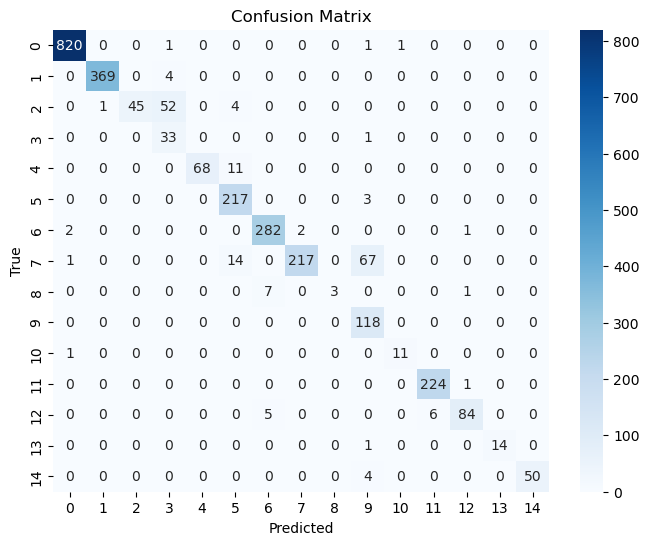

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Evaluate the model on the test set
y_pred = model.predict(X_test_cnn)  # Predictions on the test set
y_pred_classes = np.argmax(y_pred, axis=1)  # Class with highest probability

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Generate the classification report with zero_division parameter
report = classification_report(y_test, y_pred_classes, zero_division=1)
print("Classification Report:\n", report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



86/86 [==============================] - 2s 9ms/step - loss: 0.1419 - accuracy: 0.9509
Final Model Test Loss: 0.14187373220920563
Final Model Test Accuracy: 0.9508554935455322
86/86 [==============================] - 1s 8ms/step


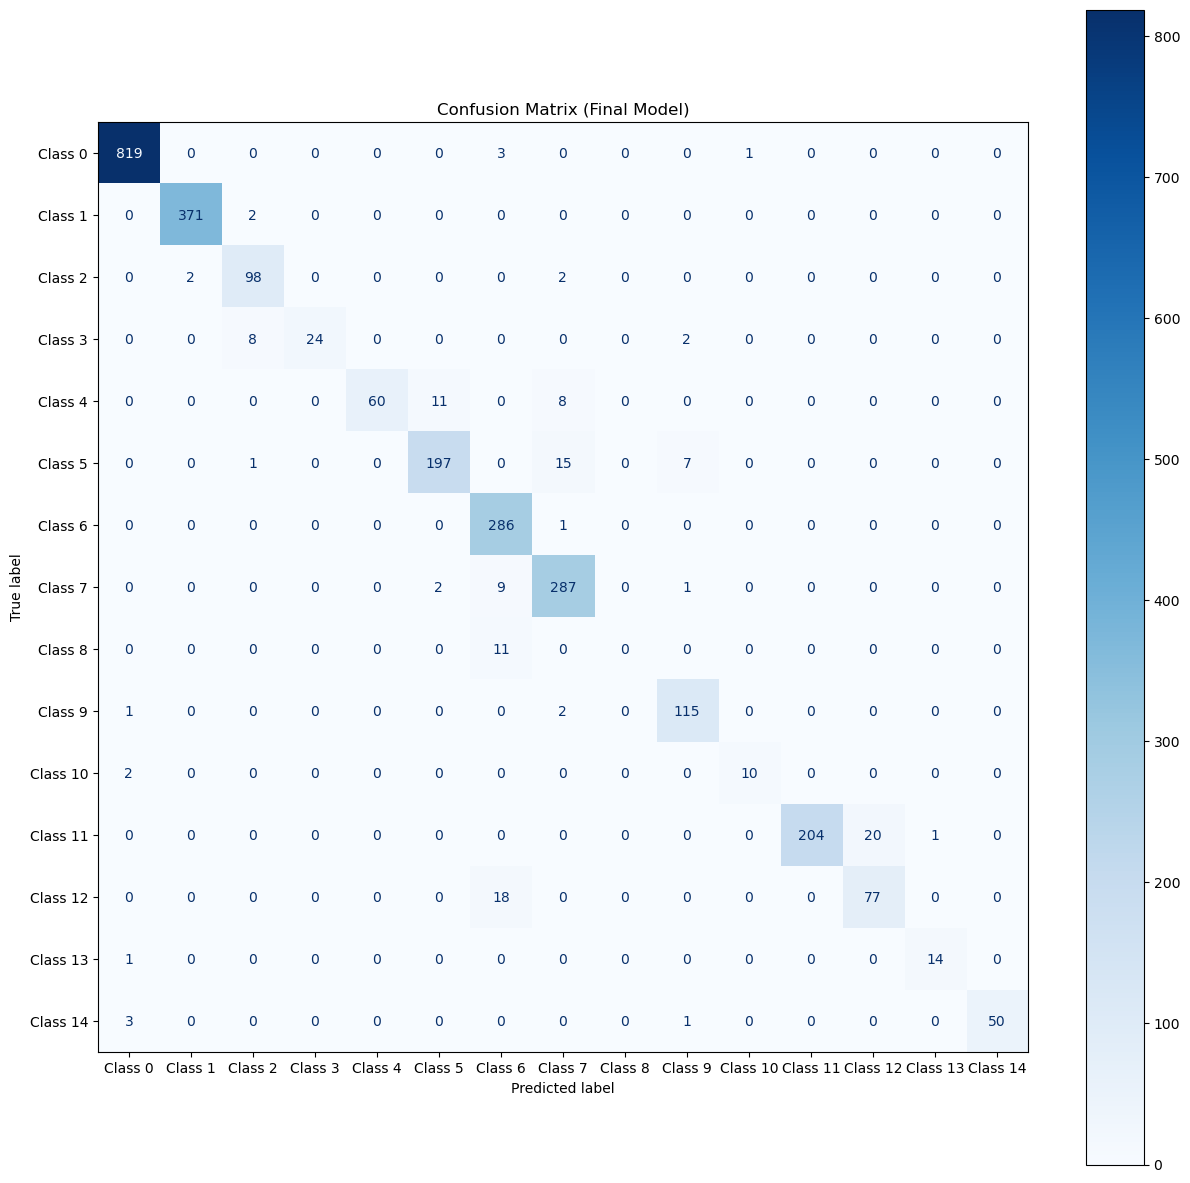

In [70]:
# Final Evaluation on the Test Set
best_model = load_model("model/best_model_active_learning.h5")
loss, accuracy = best_model.evaluate(X_test_cnn, y_test)
print(f"Final Model Test Loss: {loss}")
print(f"Final Model Test Accuracy: {accuracy}")

# Confusion Matrix
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
class_names = [f"Class {i}" for i in range(len(np.unique(y_test)))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (Final Model)")
plt.show()


#### Predicted Class Map

In [71]:
# Ensure `X_cnn` includes all labeled pixels
X_cnn = X.reshape(mask.sum(), X.shape[1], 1)  # Shape: (13734, 86, 1)

# Predict on all labeled pixels
y_pred = best_model.predict(X_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Verify the new shape
print("y_pred_classes shape:", y_pred_classes.shape)
print("Expected mask.sum():", mask.sum())

# Flatten the raster labels
rasterized_labels_flat = rasterized_labels.flatten()

# Initialize an empty array for predictions
predicted_raster_flat = np.zeros_like(rasterized_labels_flat)

# Assign predictions only to valid pixels (mask == True)
predicted_raster_flat[mask] = y_pred_classes

# Reshape back to original raster shape
predicted_raster = predicted_raster_flat.reshape(rasterized_labels.shape)

430/430 [==============================] - 3s 8ms/step
y_pred_classes shape: (13734,)
Expected mask.sum(): 13734


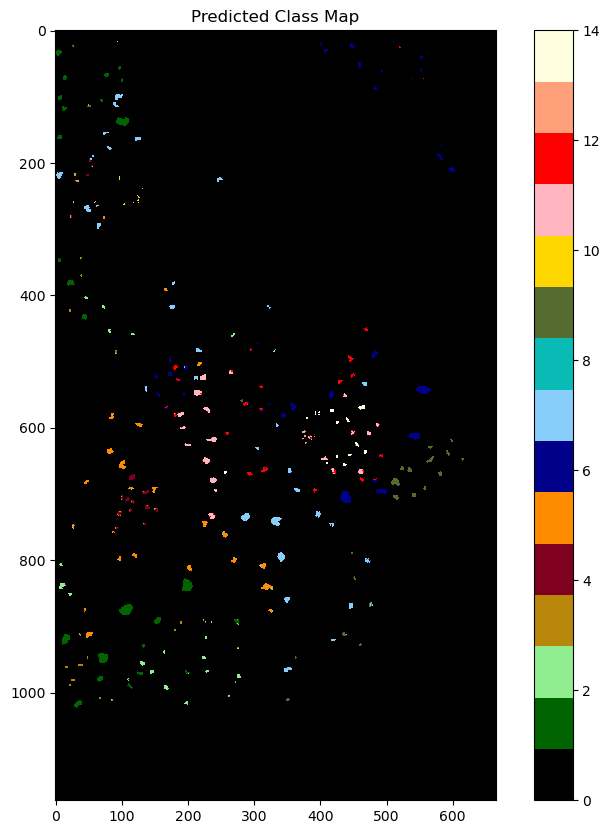

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(predicted_raster, cmap=cmap, interpolation="none")
plt.title("Predicted Class Map")
plt.colorbar()
plt.show()

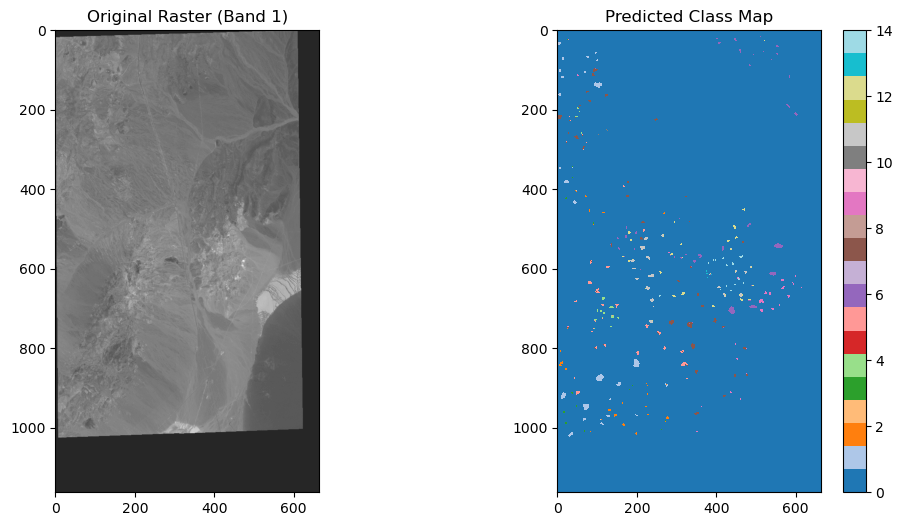

In [73]:
plt.figure(figsize=(12, 6))

# Original Raster
plt.subplot(1, 2, 1)
plt.imshow(raster_data[0], cmap="gray")
plt.title("Original Raster (Band 1)")

# Predicted Class Map
plt.subplot(1, 2, 2)
plt.imshow(predicted_raster, cmap="tab20", interpolation="none")
plt.title("Predicted Class Map")
plt.colorbar()

plt.show()


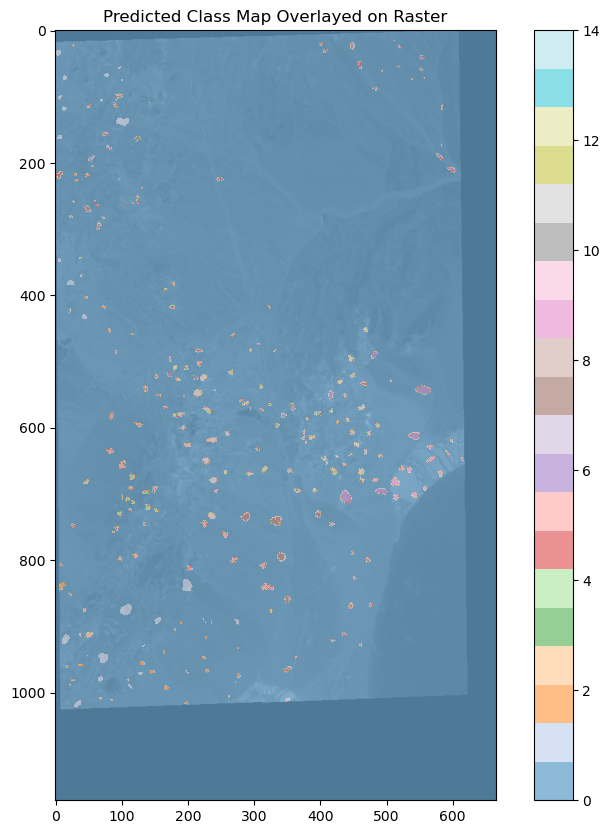

In [74]:
plt.figure(figsize=(10, 10))
plt.imshow(raster_data[0], cmap="gray", alpha=0.6)  # Base raster
plt.imshow(predicted_raster, cmap="tab20", alpha=0.5)  # Overlay predictions
plt.title("Predicted Class Map Overlayed on Raster")
plt.colorbar()
plt.show()

### Prediction/Deployment with the raw raster data


In [76]:
# Paths to the data
raster_path = "SWIR_data/AVIRIS_C_SWIR.tif"

# Load Raster Data
with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Read all bands
    raster_meta = src.meta
    transform = src.transform

# Clip negative values to zero
raster_data_clipped = np.clip(raster_data, 0, None)

# Normalize the clipped data
raster_data_normalized = (raster_data_clipped - raster_data_clipped.min()) / (raster_data_clipped.max() - raster_data_clipped.min())

# Check min and max after clipping and normalization
print(f"Min value after clipping and normalization: {raster_data_normalized.min()}")
print(f"Max value after clipping and normalization: {raster_data_normalized.max()}")

Min value after clipping and normalization: 0.0
Max value after clipping and normalization: 1.0


In [77]:
# Step 1: Flatten the spatial dimensions (height x width) into a single dimension
num_pixels = raster_data_normalized.shape[1] * raster_data_normalized.shape[2]
num_bands = raster_data_normalized.shape[0]

# Reshape the data into (num_pixels, num_bands)
X_reshaped = raster_data_normalized.reshape(num_bands, -1).T  # Shape: (num_pixels, num_bands)

# Step 2: Reshape the data into (num_pixels, num_bands, 1) for the 1D CNN
X_reshaped_cnn = X_reshaped.reshape(X_reshaped.shape[0], X_reshaped.shape[1], 1)

# Check the reshaped data shape
print(f"Reshaped raster data for 1D CNN: {X_reshaped_cnn.shape}")

Reshaped raster data for 1D CNN: (773395, 86, 1)


In [78]:
# Step 3: Load the Best Model and Predict
best_model = load_model("model/best_model_active_learning.h5")

# Step 4: Predict with the reshaped data
deployment = best_model.predict(X_reshaped_cnn)

# Step 5: Reshape Predictions to Original Raster Format
# Since 'deployment' will contain predicted class probabilities, you need to take the argmax to get the final class
predicted_raster = deployment.argmax(axis=1).reshape(raster_data.shape[1], raster_data.shape[2])


24169/24169 [==============================] - 177s 7ms/step


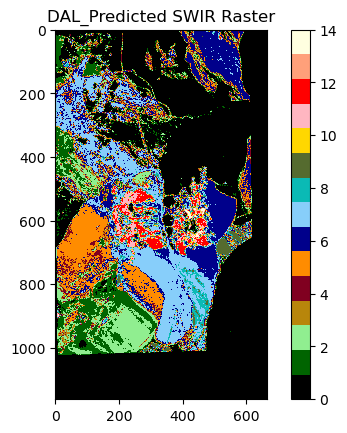

In [79]:
import os

# Display the predicted raw raster image (optional)
plt.imshow(predicted_raster, cmap=cmap) 
plt.title("DAL_Predicted SWIR Raster")
plt.colorbar()

# Define the full path and save the image
output_folder = r"C:\Users\kalac\PycharmProjects\multispectral_supervised_semisupervised_deepactivelearning\code\Output"
output_name = "DAL_predicted_swir_raster.png"
image_path = os.path.join(output_folder, output_name)  # Construct the full path
plt.savefig(image_path, dpi=300, bbox_inches="tight")

plt.show()